In [1]:
# features_utils.py

import numpy as np
import torch
from torch.utils.data import Subset

# Function to select the first `num_samples_per_class` images from each class
def select_subset(dataset, num_samples_per_class):
    # Initialize a dictionary to keep track of selected indices for each class
    class_indices = {i: [] for i in range(10)}  # CIFAR-10 has 10 classes, labeled 0-9

    # Iterate over the dataset to gather the required number of samples per class
    for index, (_, label) in enumerate(dataset):
        # Check if we have already selected enough samples for this class
        if len(class_indices[label]) < num_samples_per_class:
            class_indices[label].append(index)  # Add index to the list for this class
        # Stop if we have the required number of samples for each class
        if all(len(indices) >= num_samples_per_class for indices in class_indices.values()):
            break  # Stop iterating once we have the required samples for each class

    # Flatten the indices from all classes into a single list for creating the subset
    subset_indices = [index for indices in class_indices.values() for index in indices]
    return Subset(dataset, subset_indices)  # Return the subset with selected indices only

# Function to extract features from a dataset
def extract_features(data_loader, model):
    i = 0
    features = []
    labels = []
    with torch.no_grad():  # No gradient calculation needed for feature extraction
        for images, lbls in data_loader:
            output = model(images).squeeze()  # Get 512-dimensional feature vector
            print(f"successfully extracted features for batch {i}")
            i += 1
            features.append(output)
            labels.extend(lbls.numpy())       # Store corresponding labels
    return torch.cat(features).numpy(), np.array(labels)

In [ ]:
# feature_extraction.py

import torchvision.models as models
import numpy as np
import torch

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformation for resizing and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the CIFAR-10 datasets with the specified transform
train_data = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

# Select subsets: 500 training samples and 100 test samples per class
train_subset = select_subset(train_data, 500)
test_subset = select_subset(test_data, 100)

# Display the sizes of the training and testing subsets
print(f"Selected training subset size: {len(train_subset)}")
print(f"Selected testing subset size: {len(test_subset)}")

# Define DataLoader for batch processing
train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

# Just to confirm correct loading
for images, labels in train_loader:
    print(f"Training batch - images shape: {images.shape}, labels shape: {labels.shape}")
    break

for images, labels in test_loader:
    print(f"Testing batch - images shape: {images.shape}, labels shape: {labels.shape}")
    break

# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
feature_extractor = torch.nn.Sequential(*list(resnet18.children())[:-1])
feature_extractor.eval()

# Extract features for training subset
print("Begin feature extraction for training subset:")
train_features, train_labels = extract_features(train_loader, feature_extractor)

# Extract features for testing subset
print("\nBegin feature extraction for testing subset:")
test_features, test_labels = extract_features(test_loader, feature_extractor)

# Save the extracted features and labels
np.savez('cifar10_features.npz', train_features=train_features, train_labels=train_labels,
         test_features=test_features, test_labels=test_labels)

# verify the shape of extracted features
print("Feature extraction complete. Saved features to 'cifar10_features.npz'.")
print(f"Train subset: samples: {train_features.shape[0]}, features: {train_features.shape[1]}")
print(f"Test subset: samples: {test_features.shape[0]}, features: {test_features.shape[1]}")

Files already downloaded and verified
Files already downloaded and verified
Selected training subset size: 5000
Selected testing subset size: 1000
Training batch - images shape: torch.Size([64, 3, 224, 224]), labels shape: torch.Size([64])
Testing batch - images shape: torch.Size([64, 3, 224, 224]), labels shape: torch.Size([64])


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 62.2MB/s]


Begin feature extraction for training subset:
successfully extracted features for batch 0
successfully extracted features for batch 1
successfully extracted features for batch 2
successfully extracted features for batch 3
successfully extracted features for batch 4
successfully extracted features for batch 5
successfully extracted features for batch 6
successfully extracted features for batch 7
successfully extracted features for batch 8
successfully extracted features for batch 9
successfully extracted features for batch 10
successfully extracted features for batch 11
successfully extracted features for batch 12
successfully extracted features for batch 13
successfully extracted features for batch 14
successfully extracted features for batch 15
successfully extracted features for batch 16
successfully extracted features for batch 17
successfully extracted features for batch 18
successfully extracted features for batch 19
successfully extracted features for batch 20
successfully extrac

In [ ]:
# features_extraction_50d.py

import numpy as np

from sklearn.decomposition import PCA

# Load the extracted features (512-dimensional) from cifar10_features.npz
data = np.load('cifar10_features.npz')
train_features, train_labels = data['train_features'], data['train_labels']
test_features, test_labels = data['test_features'], data['test_labels']

# Check the initial dimensionality to ensure it's 512 for both train and test features.
assert train_features.shape[1] == 512, "Training features should be 512-dimensional."
assert test_features.shape[1] == 512, "Test features should be 512-dimensional."

# Apply PCA to reduce the feature vectors from 512 dimensions to 50 dimensions.
pca = PCA(n_components=50)

# Fit PCA on the training features and transform them to the reduced space.
train_features_50d = pca.fit_transform(train_features)

# Apply the same PCA transformation (from the training data) to the test features.
test_features_50d = pca.transform(test_features)

# Save the reduced-dimensional features (50 dimensions) and corresponding labels to a new .npz file.
np.savez('cifar10_features_50d.npz',
         train_features=train_features_50d,
         train_labels=train_labels,
         test_features=test_features_50d,
         test_labels=test_labels)

# confirm that PCA has been applied successfully.
print("PCA applied successfully. Features reduced to 50 dimensions and saved to 'cifar10_features_50d.npz'.")

# Print the shape of the reduced features.
# Train features should now have 50 dimensions instead of 512.
print(f"Train features shape after PCA: {train_features_50d.shape}")
print(f"Test features shape after PCA: {test_features_50d.shape}")

PCA applied successfully. Features reduced to 50 dimensions and saved to 'cifar10_features_50d.npz'.
Train features shape after PCA: (5000, 50)
Test features shape after PCA: (1000, 50)


In [7]:
# evaluation_utils.py

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate and display metrics
def evaluate_and_display(name, test_labels, predictions):
    accuracy = accuracy_score(test_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predictions, average='weighted')
    conf_matrix = confusion_matrix(test_labels, predictions)

    # Print metrics
    print(f"{name} - Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix
    plot_confusion_matrix(conf_matrix, name)

    return accuracy, precision, recall, f1, conf_matrix

# Plot confusion matrices
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

In [ ]:
# NB_Manual_implementation.py

class GaussianNaiveBayesManual:
    def __init__(self):
        # Initialize attributes
        self.labels = None
        self.means = {}
        self.variances = {}
        self.priors = {}

    def fit(self, features, labels):
        # Identify unique labels
        self.labels = np.unique(labels)

        # Calculate mean, variance, and prior for each class
        for label in self.labels:
            features_label = features[labels == label]      # Array that contain all the features of a specific class (label)
            self.means[label] = np.mean(features_label, axis=0)
            self.variances[label] = np.var(features_label, axis=0) + 1e-9  # Small value to avoid division by zero
            self.priors[label] = features_label.shape[0] / features.shape[0]
        print("Gaussian Naive Bayes (manual) model training complete.\n")

    def predict(self, features_dataset):
        # Predict class for each sample in features dataset
        return np.array([self._predict(sample) for sample in features_dataset])

    def _predict(self, sample):
        # Calculate the posterior for each class and choose the one with the highest probability
        posteriors = []
        for label in self.labels:
            prior = np.log(self.priors[label])
            likelihood = -0.5 * (np.sum(np.log(2 * np.pi * self.variances[label])) + np.sum(((sample - self.means[label]) ** 2) / self.variances[label]))
            posteriors.append(prior + likelihood)
        return self.labels[np.argmax(posteriors)]


In [ ]:
# NB_Train_Test.py

import numpy as np

# import the manual naive bayes implementation and the Scikit’s Gaussian Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB

# Load the 50-dimensional feature vectors and labels from PCA-reduced file
data = np.load('./cifar10_features_50d.npz')
train_features, train_labels = data['train_features'], data['train_labels']
test_features, test_labels = data['test_features'], data['test_labels']

# Initialize, train, and predict with the manual Gaussian Naive Bayes model
nb_manual = GaussianNaiveBayesManual()
nb_manual.fit(train_features, train_labels)
manual_predictions = nb_manual.predict(test_features)

# Save predictions for later use
np.savez('manual_nb_predictions.npz', predictions=manual_predictions)
print("Manual Gaussian Naive Bayes predictions saved.")

# Initialize, train, and predict with Scikit-Learn's Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(train_features, train_labels)
scikit_preds = gnb.predict(test_features)

# Save predictions for reuse
np.savez('scikit_nb_predictions.npz', predictions=scikit_preds)
print("\nScikit-Learn Gaussian Naive Bayes predictions saved.")

Gaussian Naive Bayes (manual) model training complete.

Manual Gaussian Naive Bayes predictions saved.

Scikit-Learn Gaussian Naive Bayes predictions saved.


Manual Naive Bayes - Metrics:
Accuracy: 0.7920
Precision: 0.7966
Recall: 0.7920
F1 Score: 0.7922


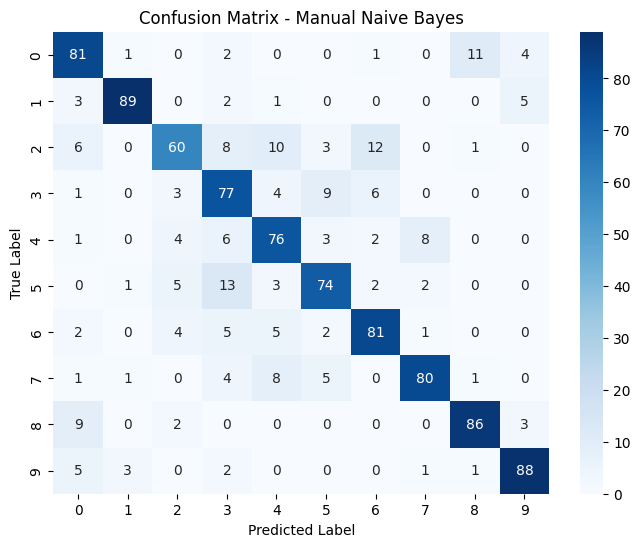


Scikit-Learn Naive Bayes - Metrics:
Accuracy: 0.7920
Precision: 0.7966
Recall: 0.7920
F1 Score: 0.7922


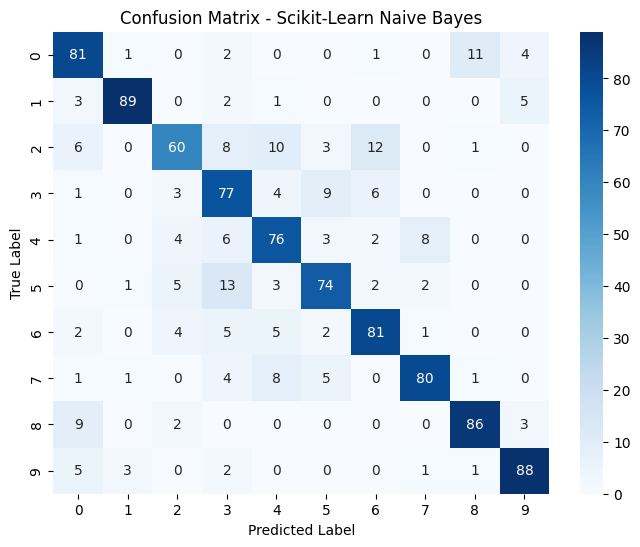


Summary Table:
                      Model  Accuracy  Precision  Recall  F1 Score
0        Manual Naive Bayes     0.792   0.796578   0.792  0.792215
1  Scikit-Learn Naive Bayes     0.792   0.796578   0.792  0.792215


In [ ]:
# NB_evaluation.py

import pandas as pd
import numpy as np

# Load training data and fit the manual decision tree model
data = np.load('./cifar10_features_50d.npz')
test_labels = data['test_labels']

# Load predictions and evaluate
manual_preds = np.load('manual_nb_predictions.npz')['predictions']
scikit_preds = np.load('scikit_nb_predictions.npz')['predictions']

# Evaluate Manual Naive Bayes
manual_metrics = evaluate_and_display("Manual Naive Bayes", test_labels, manual_preds)

print()

# Evaluate Scikit-Learn Naive Bayes
scikit_metrics = evaluate_and_display("Scikit-Learn Naive Bayes", test_labels, scikit_preds)

# Summarize findings in a table
summary_table = pd.DataFrame({
    "Model": ["Manual Naive Bayes", "Scikit-Learn Naive Bayes"],
    "Accuracy": [manual_metrics[0], scikit_metrics[0]],
    "Precision": [manual_metrics[1], scikit_metrics[1]],
    "Recall": [manual_metrics[2], scikit_metrics[2]],
    "F1 Score": [manual_metrics[3], scikit_metrics[3]]
})

# Display the summary table
print("\nSummary Table:")
print(summary_table)

In [ ]:
# DT_manual_implementation.py

import numpy as np

class SimpleDecisionTree:
    def __init__(self, max_depth=50):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, features, labels):
        # Combine features and labels into one dataset for processing
        dataset = np.column_stack((features, labels))
        self.tree = self._build_tree(dataset, depth=0)

    def _build_tree(self, dataset, depth):
        # Recursive tree-building function
        node = self._best_split(dataset)
        left, right = node['groups']
        del(node['groups'])

        # Check if we should make this node a terminal node
        if depth >= self.max_depth or not left.size or not right.size:
            node['left'] = node['right'] = self._to_terminal(np.vstack((left, right)))
            return node

        # Build left and right branches recursively
        node['left'] = self._build_tree(left, depth + 1)
        node['right'] = self._build_tree(right, depth + 1)
        return node

    def _best_split(self, dataset):
        # Determine the best split based on Gini index
        class_values = np.unique(dataset[:, -1])
        best_index, best_threshold, best_score, best_groups = None, None, float('inf'), None
        # Loops through all 50 feature indices except the label index (index 51)
        for feature_index in range(dataset.shape[1] - 1):
            for sample in dataset:
                groups = self._split(feature_index, sample[feature_index], dataset)
                gini = self._gini(groups, class_values)
                if gini < best_score:
                    best_index, best_threshold, best_score, best_groups = feature_index, sample[feature_index], gini, groups
        return {'index': best_index, 'threshold': best_threshold, 'groups': best_groups}

    def _split(self, index, threshold, dataset):
        # Split dataset based on an index and threshold
        left = dataset[dataset[:, index] < threshold]
        right = dataset[dataset[:, index] >= threshold]
        return left, right

    def _gini(self, groups, classes):
        # Calculate the Gini index for a split
        n_instances = float(sum(len(group) for group in groups))
        gini = 0.0
        for group in groups:
            size = float(len(group))
            if size == 0:
                continue
            score = sum((np.sum(group[:, -1] == class_val) / size) ** 2 for class_val in classes)
            gini += (1.0 - score) * (size / n_instances)
        return gini

    def _to_terminal(self, group):
        # Create a terminal node by selecting the most common class
        outcomes = group[:, -1]
        return np.bincount(outcomes.astype(int)).argmax()

    def predict(self, features_dataset):
        # Predict class labels for each sample in features dataset
        return np.array([self._predict(sample, self.tree) for sample in features_dataset])

    def _predict(self, sample, node):
        # Recursively predict the class based on the tree structure
        if isinstance(node, dict):
            if sample[node['index']] < node['threshold']:
                return self._predict(sample, node['left'])
            else:
                return self._predict(sample, node['right'])
        else:
            return node

In [ ]:
# DT_train_test.py

import numpy as np

from sklearn.tree import DecisionTreeClassifier

# Load training data and fit the manual decision tree model
data = np.load('./cifar10_features_50d.npz')
train_features, train_labels = data['train_features'], data['train_labels']
test_features, test_labels = data['test_features'], data['test_labels']

# Initialize train and test the SimpleDecisionTree model
dt_manual = SimpleDecisionTree(max_depth=50)
dt_manual.fit(train_features, train_labels)
manual_predictions = dt_manual.predict(test_features)

# Save predictions
np.savez('manual_dt_predictions.npz', predictions=manual_predictions)
print("Manual Decision Tree predictions saved.")

# Initialize train and test the DecisionTreeClassifier model
dt_sklearn = DecisionTreeClassifier(criterion='gini', max_depth=50, random_state=0)
dt_sklearn.fit(train_features, train_labels)
sklearn_predictions = dt_sklearn.predict(test_features)

# Save predictions for evaluation
np.savez('sklearn_dt_predictions.npz', predictions=sklearn_predictions)
print("Scikit-Learn Decision Tree predictions saved.")

Manual Decision Tree predictions saved.
Scikit-Learn Decision Tree predictions saved.


Manual Decision Tree - Metrics:
Accuracy: 0.5890
Precision: 0.5920
Recall: 0.5890
F1 Score: 0.5897


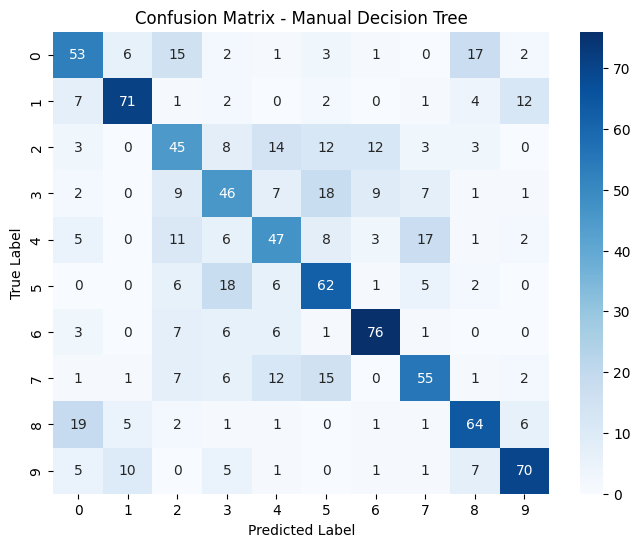


Scikit-Learn Decision Tree - Metrics:
Accuracy: 0.5840
Precision: 0.5868
Recall: 0.5840
F1 Score: 0.5843


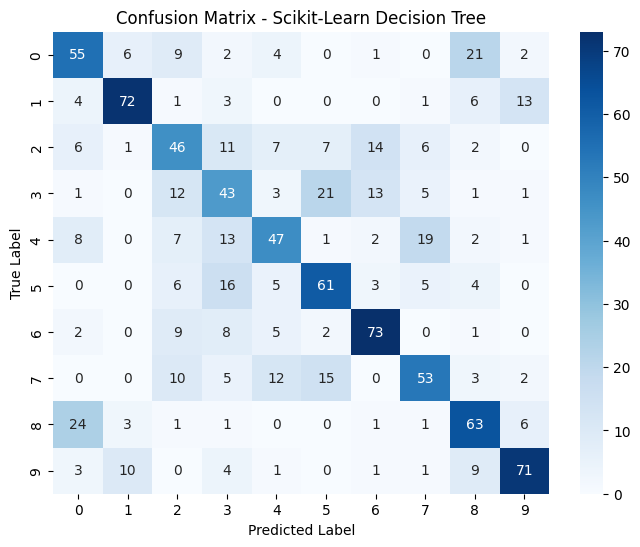


Summary Table:
                        Model  Accuracy  Precision  Recall  F1 Score
0        Manual Decision Tree     0.589   0.592029   0.589  0.589655
1  Scikit-Learn Decision Tree     0.584   0.586774   0.584  0.584303


In [ ]:
# DT_evaluation.py

import pandas as pd
import numpy as np

# Load PCA-reduced features and labels
data = np.load('./cifar10_features_50d.npz')
test_labels = data['test_labels']

# Load predictions for both models
manual_preds = np.load('manual_dt_predictions.npz')['predictions']
sklearn_preds = np.load('sklearn_dt_predictions.npz')['predictions']

# Evaluate and display metrics for manual decision tree
manual_metrics = evaluate_and_display("Manual Decision Tree", test_labels, manual_preds)

print()

# Evaluate and display metrics for Scikit-Learn Decision Tree
sklearn_metrics = evaluate_and_display("Scikit-Learn Decision Tree", test_labels, sklearn_preds)

# Summarize findings in a table
summary_table = pd.DataFrame({
    "Model": ["Manual Decision Tree", "Scikit-Learn Decision Tree"],
    "Accuracy": [manual_metrics[0], sklearn_metrics[0]],
    "Precision": [manual_metrics[1], sklearn_metrics[1]],
    "Recall": [manual_metrics[2], sklearn_metrics[2]],
    "F1 Score": [manual_metrics[3], sklearn_metrics[3]]
})

# Display the summary table
print("\nSummary Table:")
print(summary_table)

In [ ]:
# MLP_implementation.py

import torch
import torch.nn as nn
import torch.optim as optim

# Training function for mlp
def mlp_train(model, train_loader):
    print(f'Training {model.get_name()}:')

    # Loss function to compute the error
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # set learning rate and momentum
    epochs = 20  # Number of training epochs
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)           # compute predictions
            loss = criterion(outputs, labels)   # measure difference between predictions and true labels
            loss.backward()
            optimizer.step()         # update weights
            total_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")

    # Save the trained model weights
    torch.save(model.state_dict(), f'{model.get_name()}_weights.pth')
    print(f"{model.get_name()} model training complete and weights saved to {model.get_name()}_weights.pth.\n")

# Testing mlp
def mlp_test(model, test_loader, test_labels, name):
    model.eval()
    predictions = []
    with torch.no_grad():
        for features, _ in test_loader:
            outputs = model(features)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.numpy())

    # print accuracy, precision, recall and f1 score and plot confusion matrix
    return evaluate_and_display(name , test_labels, predictions)

# the three-layer MLP class contains 3 linear, 2 ReLU and 1 BatchNorm layer
class ThreeLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, name):
        super(ThreeLayerMLP, self).__init__()
        self.name = name
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.batch_norm = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.batch_norm(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

    def get_name(self):
        return self.name

# the shallow MLP class contains 2 linear, 1 ReLU and 1 BatchNorm layer
class ShallowMLP(nn.Module):
    def __init__(self, input_size=50, hidden_size=512, output_size=10):
        super(ShallowMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

    def get_name(self):
        return "shallow_layer_mlp"

# the moderate MLP class contains 3 linear, 2 ReLU and 2 BatchNorm layer
class IntermediateMLP(nn.Module):
    def __init__(self, input_size=50, hidden_size=512, output_size=10):
        super(IntermediateMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.batch_norm(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

    def get_name(self):
        return "intermediate_layer_mlp"

# the Deep MLP class contains 4 linear, 3 ReLU and 3 BatchNorm layer
class DeepMLP(nn.Module):
    def __init__(self, input_size=50, hidden_size=512, output_size=10):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.batch_norm(x)
        x = self.relu4(x)
        x = self.fc5(x)
        return x

    def get_name(self):
        return "deep_layer_mlp"

In [ ]:
# MLP_train.py

import torch

from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Load CIFAR-10 feature vectors (from PCA-reduced file with 50 dimensions)
data = np.load('./cifar10_features_50d.npz')
train_features, train_labels = data['train_features'], data['train_labels']
test_features, test_labels = data['test_features'], data['test_labels']

# Convert data to PyTorch tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Define DataLoader for batching
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize three layer mlp model
three_layer_mlp = ThreeLayerMLP(50, 512, 512, 10, "three_layer_mlp")

# Initialize mlp models for depth evaluation
shallow_layer_mlp = ShallowMLP(50, 512, 10)
intermediate_layer_mlp = IntermediateMLP(50, 512, 10)
deep_layer_mlp = DeepMLP(50, 512, 10)

# Initialize mlp models for size evaluation
small_layer_mlp = ThreeLayerMLP(50, 128, 64, 10, "small_layer_mlp")
moderate_layer_mlp = ThreeLayerMLP(50, 256, 128, 10, "moderate_layer_mlp")
large_layer_mlp = ThreeLayerMLP(50, 512, 256, 10, "large_layer_mlp")

# train the three layer mlp
mlp_train(three_layer_mlp, train_loader)

# train mlp models for depth evaluation
mlp_train(shallow_layer_mlp, train_loader)
mlp_train(intermediate_layer_mlp, train_loader)
mlp_train(deep_layer_mlp, train_loader)

# train mlp models for size evaluation
mlp_train(small_layer_mlp, train_loader)
mlp_train(moderate_layer_mlp, train_loader)
mlp_train(large_layer_mlp, train_loader)

# save the labels and features for the loader (we need it for the evaluation)
torch.save({'test_labels': test_labels_tensor, 'test_features': test_features_tensor}, 'test_data.pth')
print("Test data saved to test_data.pth.")


Training three_layer_mlp:
Epoch [1/20], Loss: 0.7633
Epoch [2/20], Loss: 0.4198
Epoch [3/20], Loss: 0.3312
Epoch [4/20], Loss: 0.2744
Epoch [5/20], Loss: 0.2247
Epoch [6/20], Loss: 0.1929
Epoch [7/20], Loss: 0.1388
Epoch [8/20], Loss: 0.1184
Epoch [9/20], Loss: 0.0917
Epoch [10/20], Loss: 0.0740
Epoch [11/20], Loss: 0.0631
Epoch [12/20], Loss: 0.0461
Epoch [13/20], Loss: 0.0366
Epoch [14/20], Loss: 0.0290
Epoch [15/20], Loss: 0.0256
Epoch [16/20], Loss: 0.0257
Epoch [17/20], Loss: 0.0470
Epoch [18/20], Loss: 0.0320
Epoch [19/20], Loss: 0.0204
Epoch [20/20], Loss: 0.0141
three_layer_mlp model training complete and weights saved to three_layer_mlp_weights.pth.

Training shallow_layer_mlp:
Epoch [1/20], Loss: 0.7919
Epoch [2/20], Loss: 0.4493
Epoch [3/20], Loss: 0.3879
Epoch [4/20], Loss: 0.3530
Epoch [5/20], Loss: 0.3259
Epoch [6/20], Loss: 0.2986
Epoch [7/20], Loss: 0.2787
Epoch [8/20], Loss: 0.2614
Epoch [9/20], Loss: 0.2479
Epoch [10/20], Loss: 0.2343
Epoch [11/20], Loss: 0.2110
Epoch

Three Layer MLP - Metrics:
Accuracy: 0.8380
Precision: 0.8425
Recall: 0.8380
F1 Score: 0.8386


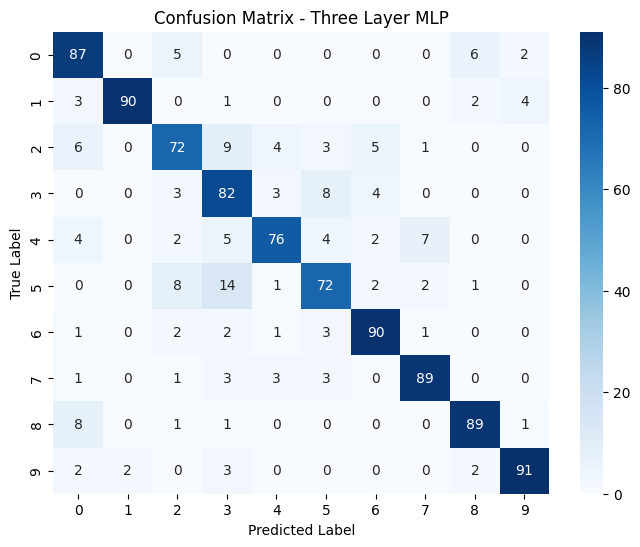


Shallow Layer MLP - Metrics:
Accuracy: 0.8400
Precision: 0.8427
Recall: 0.8400
F1 Score: 0.8400


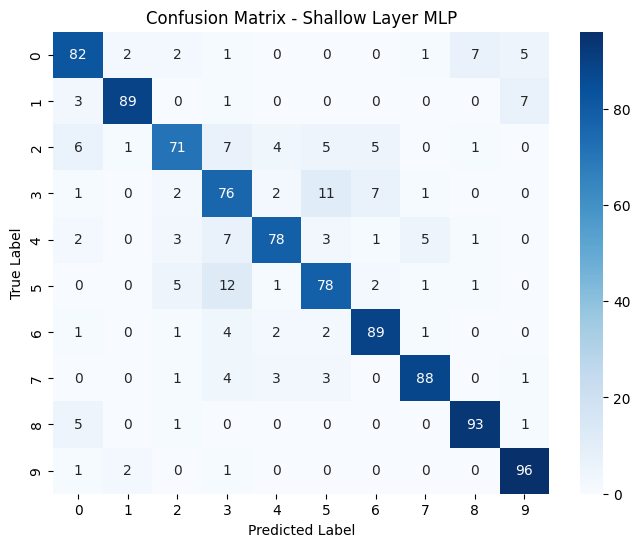


Intermediate Layer MLP - Metrics:
Accuracy: 0.8310
Precision: 0.8326
Recall: 0.8310
F1 Score: 0.8309


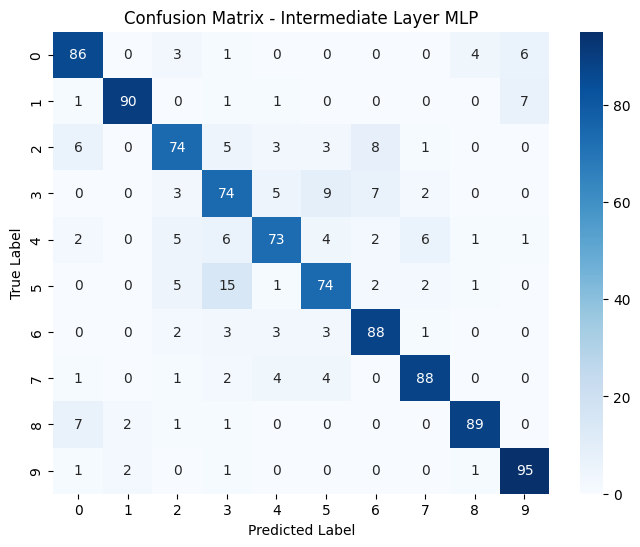


Deep Layer MLP - Metrics:
Accuracy: 0.8310
Precision: 0.8334
Recall: 0.8310
F1 Score: 0.8311


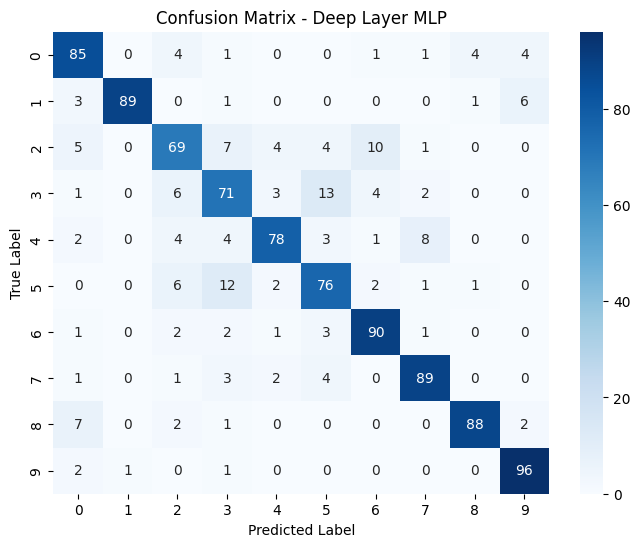


Small Layer MLP - Metrics:
Accuracy: 0.8070
Precision: 0.8078
Recall: 0.8070
F1 Score: 0.8067


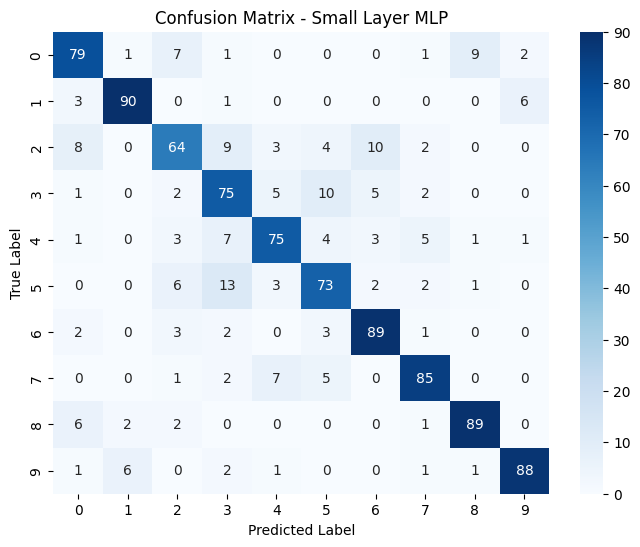


Moderate Layer MLP - Metrics:
Accuracy: 0.8050
Precision: 0.8076
Recall: 0.8050
F1 Score: 0.8045


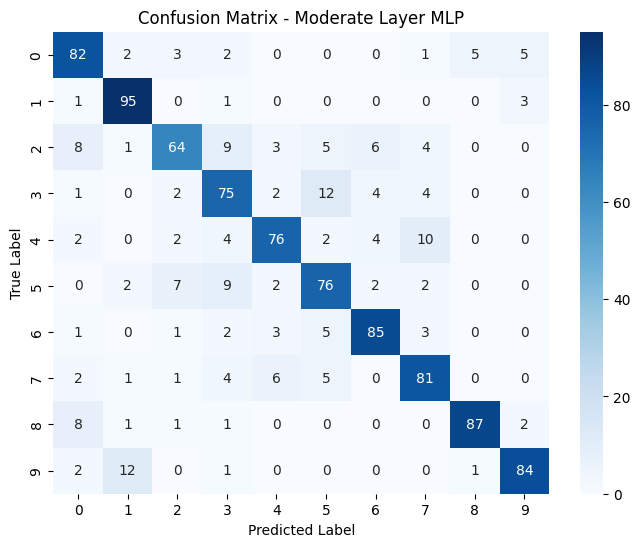


Large Layer MLP - Metrics:
Accuracy: 0.8070
Precision: 0.8114
Recall: 0.8070
F1 Score: 0.8073


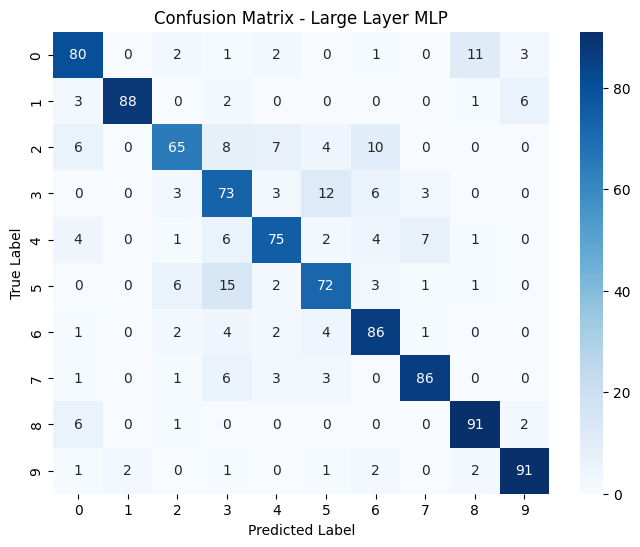


Depth Evaluation Summary Table:
              Model  Accuracy  Precision  Recall  F1 Score
0   Three Layer MLP     0.838   0.842453   0.838  0.838649
1       Shallow MLP     0.840   0.842684   0.840  0.840032
2  Intermediate MLP     0.831   0.832557   0.831  0.830918
3          Deep MLP     0.831   0.833365   0.831  0.831129

Size Evaluation Summary Table:
             Model  Accuracy  Precision  Recall  F1 Score
0  Three Layer MLP     0.838   0.842453   0.838  0.838649
1        Small MLP     0.807   0.807835   0.807  0.806650
2     Moderate MLP     0.805   0.807627   0.805  0.804514
3        Large MLP     0.807   0.811447   0.807  0.807325

All Models Evaluation Summary Table:
              Model  Accuracy  Precision  Recall  F1 Score
0   Three Layer MLP     0.838   0.842453   0.838  0.838649
1       Shallow MLP     0.840   0.842684   0.840  0.840032
2  Intermediate MLP     0.831   0.832557   0.831  0.830918
3          Deep MLP     0.831   0.833365   0.831  0.831129
4         Small M

In [ ]:
# MLP_evaluation.py

import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader

# load the data
saved_data = torch.load('test_data.pth', weights_only=True)
test_labels = saved_data['test_labels']
test_features = saved_data['test_features']

# Recreate the DataLoader
test_dataset = TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize three layer mlp model
three_layer_mlp = ThreeLayerMLP(50, 512, 512, 10, "three_layer_mlp")

# Initialize mlp models for depth evaluation
shallow_layer_mlp = ShallowMLP(50, 512, 10)
intermediate_layer_mlp = IntermediateMLP(50, 512, 10)
deep_layer_mlp = DeepMLP(50, 512, 10)

# Initialize mlp models for size evaluation
small_layer_mlp = ThreeLayerMLP(50, 128, 64, 10, "small_layer_mlp")
moderate_layer_mlp = ThreeLayerMLP(50, 256, 128, 10, "moderate_layer_mlp")
large_layer_mlp = ThreeLayerMLP(50, 512, 256, 10, "large_layer_mlp")

# load weights into the models
three_layer_mlp.load_state_dict(torch.load('three_layer_mlp_weights.pth', weights_only=True))
shallow_layer_mlp.load_state_dict(torch.load('shallow_layer_mlp_weights.pth', weights_only=True))
intermediate_layer_mlp.load_state_dict(torch.load('intermediate_layer_mlp_weights.pth', weights_only=True))
deep_layer_mlp.load_state_dict(torch.load('deep_layer_mlp_weights.pth', weights_only=True))
small_layer_mlp.load_state_dict(torch.load('small_layer_mlp_weights.pth', weights_only=True))
moderate_layer_mlp.load_state_dict(torch.load('moderate_layer_mlp_weights.pth', weights_only=True))
large_layer_mlp.load_state_dict(torch.load('large_layer_mlp_weights.pth', weights_only=True))

# Set the models to evaluation mode
three_layer_mlp.eval()
shallow_layer_mlp.eval()
intermediate_layer_mlp.eval()
deep_layer_mlp.eval()
small_layer_mlp.eval()
moderate_layer_mlp.eval()
large_layer_mlp.eval()

# Evaluate every mlp model and plot confusion matrix
three_layer_metrics = mlp_test(three_layer_mlp, test_loader, test_labels, "Three Layer MLP")
print()
shallow_metrics = mlp_test(shallow_layer_mlp, test_loader, test_labels, "Shallow Layer MLP")
print()
intermediate_metrics = mlp_test(intermediate_layer_mlp, test_loader, test_labels, "Intermediate Layer MLP")
print()
deep_metrics = mlp_test(deep_layer_mlp, test_loader, test_labels, "Deep Layer MLP")
print()
small_metrics = mlp_test(small_layer_mlp, test_loader, test_labels, "Small Layer MLP")
print()
moderate_metrics = mlp_test(moderate_layer_mlp, test_loader, test_labels, "Moderate Layer MLP")
print()
large_metrics = mlp_test(large_layer_mlp, test_loader, test_labels, "Large Layer MLP")

# Save evaluation summary to display depth results
depth_evaluation_results = pd.DataFrame({
    'Model': ['Three Layer MLP', 'Shallow MLP', 'Intermediate MLP', 'Deep MLP'],
    'Accuracy': [three_layer_metrics[0], shallow_metrics[0], intermediate_metrics[0], deep_metrics[0]],
    'Precision': [three_layer_metrics[1], shallow_metrics[1],  intermediate_metrics[1], deep_metrics[1]],
    'Recall': [three_layer_metrics[2], shallow_metrics[2], intermediate_metrics[2], deep_metrics[2]],
    'F1 Score': [three_layer_metrics[3], shallow_metrics[3], intermediate_metrics[3], deep_metrics[3]]
})

print("\nDepth Evaluation Summary Table:")
print(depth_evaluation_results)

# Save evaluation summary to display different size results
size_evaluation_results = pd.DataFrame({
    'Model': ['Three Layer MLP', 'Small MLP', 'Moderate MLP', 'Large MLP'],
    'Accuracy': [three_layer_metrics[0], small_metrics[0], moderate_metrics[0], large_metrics[0]],
    'Precision': [three_layer_metrics[1], small_metrics[1],  moderate_metrics[1], large_metrics[1]],
    'Recall': [three_layer_metrics[2], small_metrics[2], moderate_metrics[2], large_metrics[2]],
    'F1 Score': [three_layer_metrics[3], small_metrics[3], moderate_metrics[3], large_metrics[3]]
})

print("\nSize Evaluation Summary Table:")
print(size_evaluation_results)

# Save evaluation summary to display all results
mlp_evaluation_results = pd.DataFrame({
    'Model': ['Three Layer MLP', 'Shallow MLP', 'Intermediate MLP', 'Deep MLP', 'Small MLP', 'Moderate MLP', 'Large MLP'],
    'Accuracy': [three_layer_metrics[0], shallow_metrics[0], intermediate_metrics[0], deep_metrics[0], small_metrics[0], moderate_metrics[0], large_metrics[0]],
    'Precision': [three_layer_metrics[1], shallow_metrics[1],  intermediate_metrics[1], deep_metrics[1], small_metrics[1],  moderate_metrics[1], large_metrics[1]],
    'Recall': [three_layer_metrics[2], shallow_metrics[2], intermediate_metrics[2], deep_metrics[2], small_metrics[2], moderate_metrics[2], large_metrics[2]],
    'F1 Score': [three_layer_metrics[3], shallow_metrics[3], intermediate_metrics[3], deep_metrics[3], small_metrics[3], moderate_metrics[3], large_metrics[3]]
})

print("\nAll Models Evaluation Summary Table:")
print(mlp_evaluation_results)

In [20]:
# CNN_implementation.py

import torch
import torch.nn as nn
import torch.optim as optim

def cnn_train(model, train_loader, criterion, device):
    print(f"\nBegin {model.get_name()} training:")
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    model.train()
    total_epochs = 20
    for epoch in range(total_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{total_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Save the trained model weights
    torch.save(model.state_dict(), f'{model.get_name()}_weights.pth')
    print(f"{model.get_name()} model training complete and weights saved to {model.get_name()}_weights.pth.\n")

def cnn_test(model, test_loader, criterion, device, name):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_labels = []
    predictions = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            test_labels.extend(labels.cpu().numpy())  # Move to CPU for compatibility
            predictions.extend(predicted.cpu().numpy())  # Move to CPU for compatibility

    # print accuracy, precision, recall and f1 score and plot confusion matrix
    return evaluate_and_display(name , test_labels, predictions)

# define cnn class
class CNN(nn.Module):
    def __init__(self, name, kernel_size):
        super(CNN, self).__init__()
        self.name = name

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce dimensions (split by 2)

            nn.Conv2d(64, 128, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce dimensions (split by 2)

            nn.Conv2d(128, 256, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce dimensions (split by 2)

            nn.Conv2d(256, 512, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce dimensions (split by 2)

            nn.Conv2d(512, 512, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # reduce dimensions (split by 2)
        )

        # used to produce class probabilities
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) # flatten to a 1D vector
        x = self.classifier(x)
        return x

    def get_name(self):
        return self.name

# define shallow cnn class (4 blocks)
class ShallowCNN(nn.Module):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce dimensions (split by 2)

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce dimensions (split by 2)
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce dimensions (split by 2)

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce dimensions (split by 2)

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # reduce dimensions (split by 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096), # adjust input size
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def get_name(self):
        return "shallow_cnn"

# definition for deep cnn (12 blocks)
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Block 2
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce dimensions (split by 2)

            # Block 4
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Block 5
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Block 6
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce dimensions (split by 2)

            # Block 7
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # Block 8
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce dimensions (split by 2)

            # Block 9
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # Block 10
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce dimensions (split by 2)

            # Block 11
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # Block 12
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # reduce dimensions (split by 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def get_name(self):
        return "deep_cnn"

class LargeCNN(nn.Module):
    def __init__(self, name, kernel_size):
        super(LargeCNN, self).__init__()
        self.name = name

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=kernel_size, stride=1, padding=kernel_size // 2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=kernel_size, stride=1, padding=kernel_size // 2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=kernel_size, stride=1, padding=kernel_size // 2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=kernel_size, stride=1, padding=kernel_size // 2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=kernel_size, stride=1, padding=kernel_size // 2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=kernel_size, stride=1, padding=kernel_size // 2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=kernel_size, stride=1, padding=kernel_size // 2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=kernel_size, stride=1, padding=kernel_size // 2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Dynamically adjust the input size of the classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten to a 1D vector
        x = self.classifier(x)
        return x

    def get_name(self):
        return self.name

In [14]:
# CNN_train.py

import torch
import torch.nn as nn

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# define transform
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally to better train the model
    transforms.RandomCrop(32, padding=4),  # Add padding and crop to better train the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the CIFAR-10 datasets with the specified transform
train_data = datasets.CIFAR10(root='../../data', train=True, download=True, transform=transform)

# Select subsets: first 500 training samples per class
train_subset = select_subset(train_data, 500)

# Define DataLoader for batch processing
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

# initialize device and set it to GPU. if no GPU available use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize loss function
criterion = nn.CrossEntropyLoss()

# initialize default cnn model
cnn = CNN("VGG11", 3).to(device)

# initialize cnn models for depth evaluation
shallow_cnn = ShallowCNN().to(device)
deep_cnn = DeepCNN().to(device)

# initialize cnn models for size evaluation
large_cnn = LargeCNN("large_cnn", 5).to(device)
very_large_cnn = LargeCNN("very_large_cnn", 7).to(device)

# train all models
cnn_train(cnn, train_loader, criterion, device)

cnn_train(shallow_cnn, train_loader, criterion, device)
cnn_train(deep_cnn, train_loader, criterion, device)

cnn_train(large_cnn, train_loader, criterion, device)
cnn_train(very_large_cnn, train_loader, criterion, device)

Files already downloaded and verified

Begin VGG11 training:
Epoch [1/20], Loss: 2.0321
Epoch [2/20], Loss: 1.7569
Epoch [3/20], Loss: 1.6172
Epoch [4/20], Loss: 1.5064
Epoch [5/20], Loss: 1.4426
Epoch [6/20], Loss: 1.4373
Epoch [7/20], Loss: 1.2926
Epoch [8/20], Loss: 1.2251
Epoch [9/20], Loss: 1.1876
Epoch [10/20], Loss: 1.1255
Epoch [11/20], Loss: 1.0713
Epoch [12/20], Loss: 1.0468
Epoch [13/20], Loss: 0.9744
Epoch [14/20], Loss: 0.9210
Epoch [15/20], Loss: 0.9092
Epoch [16/20], Loss: 0.8953
Epoch [17/20], Loss: 0.8594
Epoch [18/20], Loss: 0.7760
Epoch [19/20], Loss: 0.7582
Epoch [20/20], Loss: 0.7615
VGG11 model training complete and weights saved to VGG11_weights.pth.


Begin shallow_cnn training:
Epoch [1/20], Loss: 1.9796
Epoch [2/20], Loss: 1.6728
Epoch [3/20], Loss: 1.5364
Epoch [4/20], Loss: 1.4521
Epoch [5/20], Loss: 1.3921
Epoch [6/20], Loss: 1.3224
Epoch [7/20], Loss: 1.2492
Epoch [8/20], Loss: 1.2170
Epoch [9/20], Loss: 1.1874
Epoch [10/20], Loss: 1.1385
Epoch [11/20], Lo

Files already downloaded and verified

Testing VGG11:
VGG11 (Subset) - Metrics:
Accuracy: 0.6820
Precision: 0.6795
Recall: 0.6820
F1 Score: 0.6747


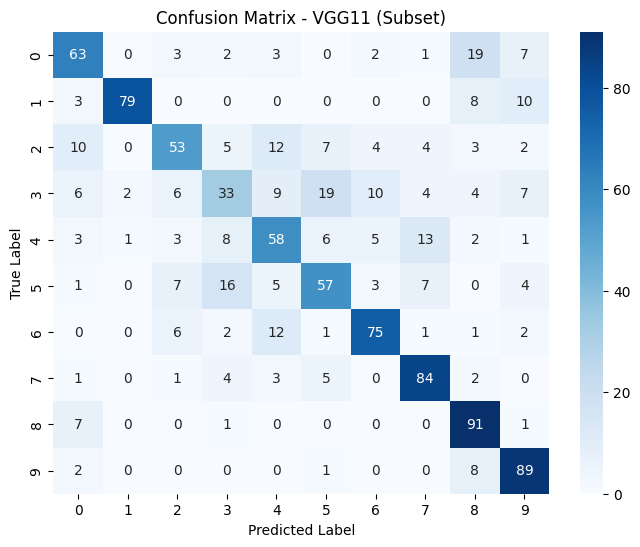


Testing Shallow CNN:
Shallow CNN (4 blocks) - Metrics:
Accuracy: 0.6450
Precision: 0.6706
Recall: 0.6450
F1 Score: 0.6429


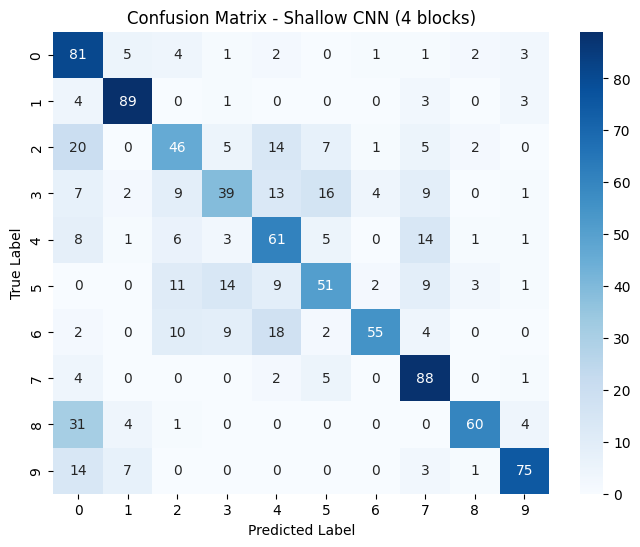


Testing Deep CNN:
Deep CNN (12 blocks) - Metrics:
Accuracy: 0.6810
Precision: 0.6895
Recall: 0.6810
F1 Score: 0.6708


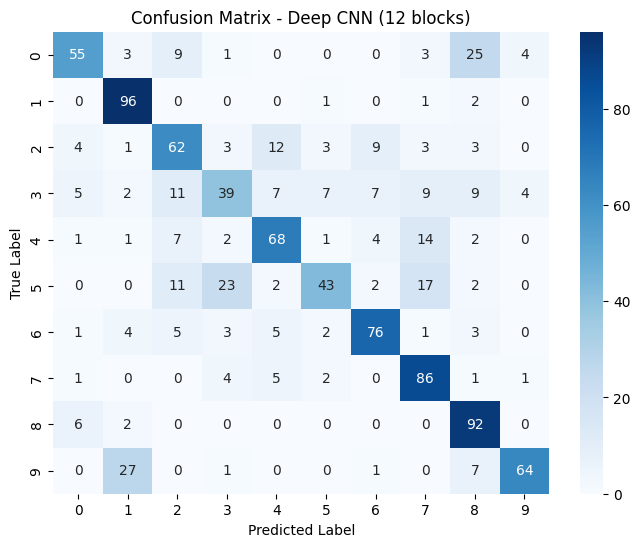


Testing Large CNN:
Large Kernel CNN (7x7) - Metrics:
Accuracy: 0.5760
Precision: 0.5986
Recall: 0.5760
F1 Score: 0.5618


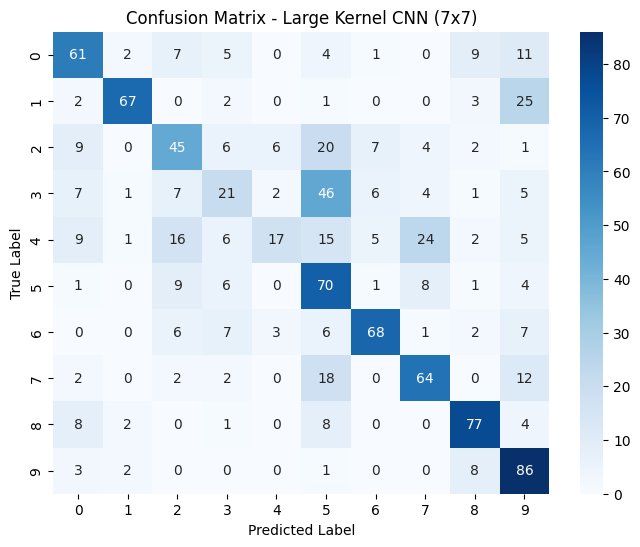


Testing Very Large CNN:
Very Large Kernel CNN (9x9) - Metrics:
Accuracy: 0.5440
Precision: 0.5317
Recall: 0.5440
F1 Score: 0.5219


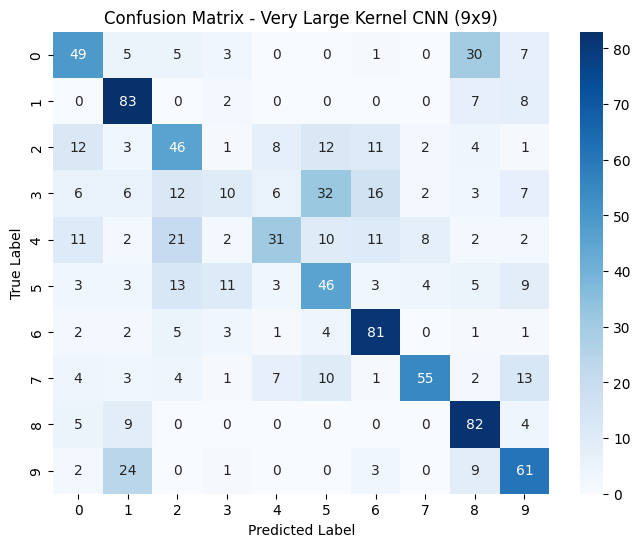


Depth Evaluation Summary Table:
            Model  Accuracy  Precision  Recall  F1 Score
0  VGG11 (Subset)     0.682   0.679513   0.682  0.674675
1     Shallow CNN     0.645   0.670613   0.645  0.642881
2        Deep CNN     0.681   0.689494   0.681  0.670847

Kernel Size Evaluation Summary Table:
                   Model  Accuracy  Precision  Recall  F1 Score
0         VGG11 (Subset)     0.682   0.679513   0.682  0.674675
1       Large Kernel CNN     0.576   0.598610   0.576  0.561826
2  Very Large Kernel CNN     0.544   0.531708   0.544  0.521911

All Models Evaluation Summary Table:
                   Model  Accuracy  Precision  Recall  F1 Score
0         VGG11 (Subset)     0.682   0.679513   0.682  0.674675
1            Shallow CNN     0.645   0.670613   0.645  0.642881
2               Deep CNN     0.681   0.689494   0.681  0.670847
3       Large Kernel CNN     0.576   0.598610   0.576  0.561826
4  Very Large Kernel CNN     0.544   0.531708   0.544  0.521911


In [26]:
# CNN_evaluation.py

import torch
import pandas as pd

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the CIFAR-10 datasets with the specified transform
test_data = datasets.CIFAR10(root='../../data', train=False, download=True, transform=transform)

# Select subsets: first 100 test samples per class
test_subset = select_subset(test_data, 100)

# Define DataLoader for batch processing
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

# initialize device and set it to GPU. if no GPU available use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize loss function
criterion = nn.CrossEntropyLoss()

# initialize default cnn model
cnn = CNN("cnn", 3).to(device)

# initialize cnn models for depth evaluation
shallow_cnn = ShallowCNN().to(device)
deep_cnn = DeepCNN().to(device)

# initialize cnn models for size evaluation
large_cnn = LargeCNN("large_cnn", 5).to(device)
very_large_cnn = LargeCNN("very_large_cnn", 7).to(device)

# Load saved weights
cnn.load_state_dict(torch.load("VGG11_weights.pth", weights_only=True))

shallow_cnn.load_state_dict(torch.load("shallow_cnn_weights.pth", weights_only=True))
deep_cnn.load_state_dict(torch.load("deep_cnn_weights.pth", weights_only=True))

large_cnn.load_state_dict(torch.load("large_cnn_weights.pth", weights_only=True))
very_large_cnn.load_state_dict(torch.load("very_large_cnn_weights.pth", weights_only=True))

# Test the models
print("\nTesting VGG11:")
vgg11_metrics = cnn_test(cnn, test_loader, criterion, device, "VGG11 (Subset)")

print("\nTesting Shallow CNN:")
shallow_metrics = cnn_test(shallow_cnn, test_loader, criterion, device, "Shallow CNN (4 blocks)")

print("\nTesting Deep CNN:")
deep_metrics = cnn_test(deep_cnn, test_loader, criterion, device, "Deep CNN (12 blocks)")

print("\nTesting Large CNN:")
large_metrics = cnn_test(large_cnn, test_loader, criterion, device, "Large Kernel CNN (7x7)")

print("\nTesting Very Large CNN:")
very_large_metrics = cnn_test(very_large_cnn, test_loader, criterion, device, "Very Large Kernel CNN (9x9)")

# Save evaluation summary to display depth results
depth_evaluation_results = pd.DataFrame({
    'Model': ['VGG11 (Subset)', 'Shallow CNN', 'Deep CNN'],
    'Accuracy': [vgg11_metrics[0], shallow_metrics[0], deep_metrics[0]],
    'Precision': [vgg11_metrics[1], shallow_metrics[1], deep_metrics[1]],
    'Recall': [vgg11_metrics[2], shallow_metrics[2], deep_metrics[2]],
    'F1 Score': [vgg11_metrics[3], shallow_metrics[3], deep_metrics[3]]
})

print("\nDepth Evaluation Summary Table:")
print(depth_evaluation_results)

# Save evaluation summary to display different size results
size_evaluation_results = pd.DataFrame({
    'Model': ['VGG11 (Subset)', 'Large Kernel CNN', 'Very Large Kernel CNN'],
    'Accuracy': [vgg11_metrics[0], large_metrics[0], very_large_metrics[0]],
    'Precision': [vgg11_metrics[1], large_metrics[1],  very_large_metrics[1]],
    'Recall': [vgg11_metrics[2], large_metrics[2], very_large_metrics[2]],
    'F1 Score': [vgg11_metrics[3], large_metrics[3], very_large_metrics[3]]
})

print("\nKernel Size Evaluation Summary Table:")
print(size_evaluation_results)

# Save evaluation summary to display all results
evaluation_results = pd.DataFrame({
    'Model': ['VGG11 (Subset)', 'Shallow CNN', 'Deep CNN', 'Large Kernel CNN', 'Very Large Kernel CNN'],
    'Accuracy': [vgg11_metrics[0], shallow_metrics[0], deep_metrics[0], large_metrics[0], very_large_metrics[0]],
    'Precision': [vgg11_metrics[1], shallow_metrics[1], deep_metrics[1], large_metrics[1], very_large_metrics[1]],
    'Recall': [vgg11_metrics[2], shallow_metrics[2], deep_metrics[2], large_metrics[2], very_large_metrics[2]],
    'F1 Score': [vgg11_metrics[3], shallow_metrics[3], deep_metrics[3], large_metrics[3], very_large_metrics[3]]
})

print("\nAll Models Evaluation Summary Table:")
print(evaluation_results)

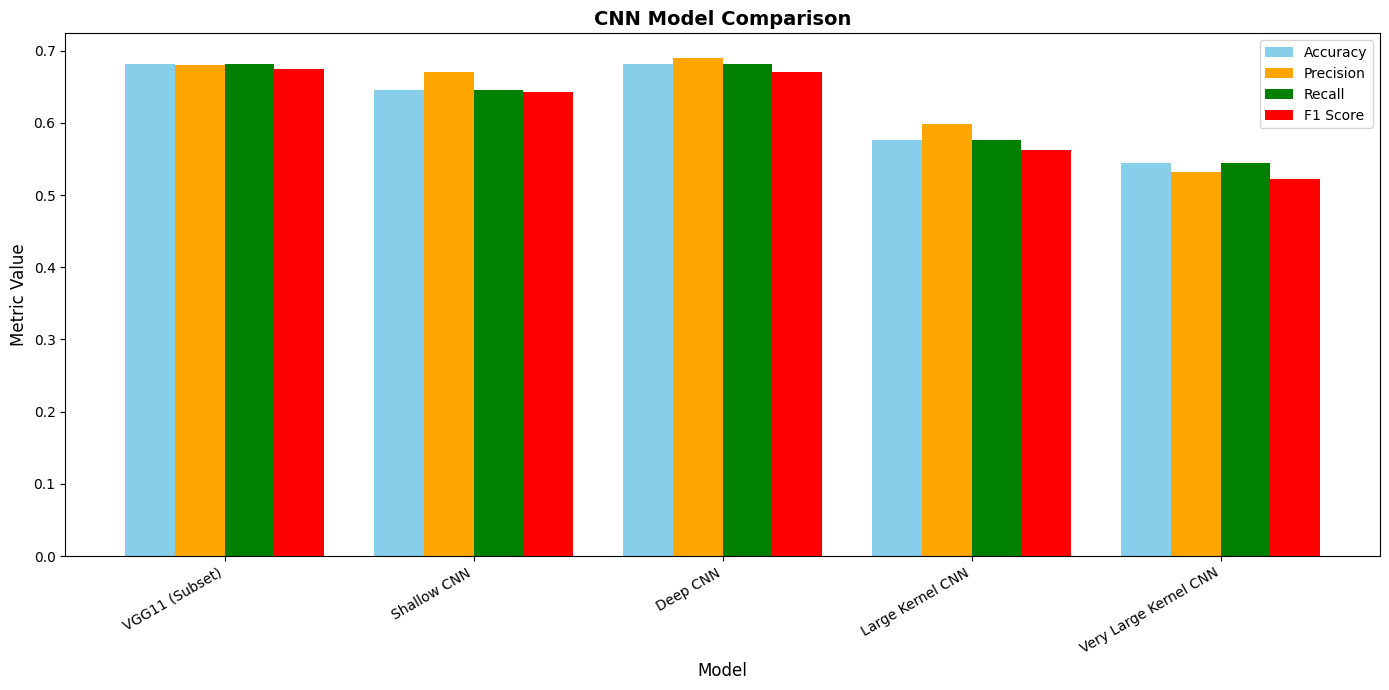

In [27]:
# Model comparison graph
results_df = pd.DataFrame(evaluation_results)
x = np.arange(len(results_df["Model"]))  # label locations
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(x - 1.5 * width, results_df["Accuracy"], width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x - 0.5 * width, results_df["Precision"], width, label='Precision', color='orange')
rects3 = ax.bar(x + 0.5 * width, results_df["Recall"], width, label='Recall', color='green')
rects4 = ax.bar(x + 1.5 * width, results_df["F1 Score"], width, label='F1 Score', color='red')

# Adding labels, title, and customizing x-axis
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Metric Value', fontsize=12)
ax.set_title('CNN Model Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df["Model"], rotation=30, ha="right", fontsize=10)
ax.legend()

# Finalizing the layout
fig.tight_layout()

# Display the graph
plt.show()

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Loss: 1.2914
Epoch 2/20, Loss: 0.8401
Epoch 3/20, Loss: 0.6466
Epoch 4/20, Loss: 0.5198
Epoch 5/20, Loss: 0.4191
Epoch 6/20, Loss: 0.3355
Epoch 7/20, Loss: 0.2670
Epoch 8/20, Loss: 0.2122
Epoch 9/20, Loss: 0.1762
Epoch 10/20, Loss: 0.1367
Epoch 11/20, Loss: 0.1077
Epoch 12/20, Loss: 0.0977
Epoch 13/20, Loss: 0.0789
Epoch 14/20, Loss: 0.0692
Epoch 15/20, Loss: 0.0520
Epoch 16/20, Loss: 0.0530
Epoch 17/20, Loss: 0.0450
Epoch 18/20, Loss: 0.0378
Epoch 19/20, Loss: 0.0336
Epoch 20/20, Loss: 0.0330


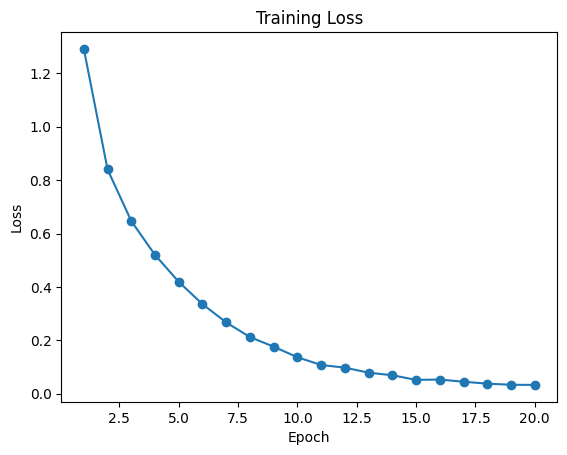

VGG11 predictions saved.
Accuracy: 0.8263
Precision: 0.8313
Recall: 0.8263
F1 Score: 0.8258


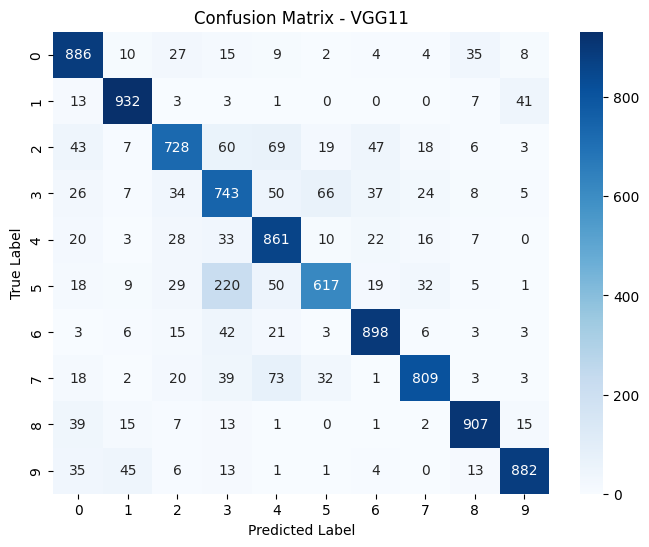

Evaluation metrics saved to 'vgg11_evaluation.csv'.


In [ ]:
#VG11 trained on the whole dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import numpy as np
import pandas as pd

# Define the VGG11 architecture
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Define transformations for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Ensure consistent image size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for RGB input
])

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG11().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
epochs = 20
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

# Plot training loss
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Save predictions
np.savez('vgg11_predictions.npz', predictions=np.array(all_preds), true_labels=np.array(all_labels))
print("VGG11 predictions saved.")

# Evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - VGG11")
plt.show()

# Save results to a CSV file
results_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Value": [accuracy, precision, recall, f1]
})
results_df.to_csv('vgg11_evaluation.csv', index=False)
print("Evaluation metrics saved to 'vgg11_evaluation.csv'.")
